# still in experiment phase-  not working

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os, sys, time
import numpy as np
import pandas as pd
sys.path.append('../')
from utils.camera import Camera
import tensorflow as tf
from tensorflow import keras
# import warnings
#warnings.filterwarnings('ignore')

In [2]:
base_model_class = keras.applications.MobileNetV2
base_model_preprocess_function = keras.applications.mobilenet_v2.preprocess_input

#base_model_class = keras.applications.InceptionV3
#base_model_preprocess_function = keras.applications.inception_v3.preprocess_input

In [3]:
model = keras.models.load_model(f'../models/model_fingers_{base_model_class.__name__}')

In [16]:
# preprocess
def preprocess_image(img):
    start_time= time.time()
    img = img.resize(tuple(model.input.shape)[1:3])
    img_array = np. array(img)
    img_array = img_array.reshape(1, model.input.shape[1], model.input.shape[2], model.input.shape[3])
    img_array = base_model_preprocess_function(img_array)
    duration = time.time() - start_time
    return img_array, duration  

In [11]:
# predict
def predict_from_image_array(img_array):
    start_time= time.time()
    pred_proba = model.predict(img_array)
    duration = time.time() - start_time
    return pd.DataFrame({
        'label' : [labels[i] for i in labels.keys()],
        'proba' : list(pred_proba[0])}), duration

In [25]:
labels = {i: str(i) for i in range(6)}

## predict from camera

In [4]:
# initialize only one time
if 'camera0' not in locals():
    camera0 = Camera(capture_device=0, width=224, height=224, 
                     capture_width=1280, capture_height=720, capture_fps=30, flip_mode=-1, debug=True)

nvarguscamerasrc sensor-id=0 ! video/x-raw(memory:NVMM), width=1280, height=720,                 format=(string)NV12, framerate=(fraction)30/1 ! nvvidconv ! video/x-raw, width=(int)224,                 height=(int)224, format=(string)BGRx ! videoconvert ! appsink drop=true sync=false


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


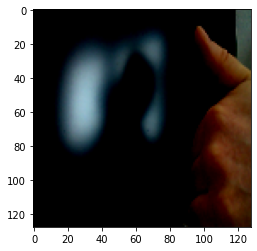

In [54]:
img_rgb = camera0.get_image_rgb()
img = Image.fromarray(img_rgb, 'RGB')
img_array, duration_preprocess = preprocess_image(img)
df, duration_predict = predict_from_image_array(img_array)
df
#pred_label = df.nlargest(1, 'proba')[['label','proba']].values[0][0]
#pred_proba = df.nlargest(1, 'proba')[['label','proba']].values[0][1]
#print(f'{pred_label} - time preprocess / prediction:{duration_preprocess:0.2f}s / {duration_predict:0.2f}s')
plt.imshow(img_array.reshape(128, 128, 3))

## live camera

In [38]:
duration = 30 # running time in seconds

from IPython.display import display
import ipywidgets.widgets as widgets
image_widget = widgets.Image(format='jpeg', width=300, height=300)
label_widget = widgets.Text(description='detected')
confidence_widget = widgets.Text(description='confidence')
time_widget = widgets.Text(description='pred. time')
progress_widget = widgets.FloatProgress(value=0, min=0.0, max=float(duration), description='running time')

display(widgets.HBox([image_widget, 
                      widgets.VBox([label_widget, confidence_widget, time_widget, progress_widget])]))

start_time = time.time()
while time.time() - start_time < duration:
    img_rgb = camera0.get_image_rgb()
    img = Image.fromarray(img_rgb, 'RGB')
    img_array, duration_preprocess = preprocess_image(img)
    df, duration_predict = predict_from_image_array(img_array)
    pred_label = df.nlargest(1, 'proba')[['label','proba']].values[0][0].split(',')[0]
    pred_proba = df.nlargest(1, 'proba')[['label','proba']].values[0][1]
    label_widget.value = pred_label
    confidence_widget.value = f'{pred_proba *100:0.0f} %'
    time_widget.value = f'{duration_predict:0.2f} sec'
    image_widget.value = bytes(cv2.imencode('.jpg', img_rgb)[1])
    progress_widget.value = (time.time() - start_time)

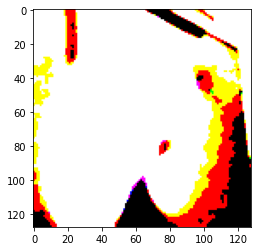

In [70]:
img = camera0.get_image_rgb()
#img = Image.fromarray(img_rgb, 'RGB')
img = cv2.resize(img, (128, 128))
img = cv2.GaussianBlur(img,(5,5),0)
_,img = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
im_floodfill = img.copy()
#h, w = img.shape[:2]
#mask = np.zeros((h+2, w+2), np.uint8)
#cv2.floodFill(im_floodfill, mask, (0,0), 255)
#im_floodfill_inv = cv2.bitwise_not(im_floodfill)
#img = img | im_floodfill_inv


#img = img/255

# plt.imshow(img_array.reshape(128, 128, 3))
plt.imshow(img)
